In [1]:
# !pip install oolearning --upgrade

In [2]:
import copy
import os
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import column_log, BinaryAucRocScore, create_net_capital, strip_strings

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [4]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [5]:
n_positive = np.sum(explore.dataset[target_variable] == positive_class)
n_negative = np.sum(explore.dataset.income == negative_class)
scale_pos_weight_calc = n_negative / n_positive
scale_pos_weight_calc

3.034796573875803

In [6]:
global_transformations = [
    # kaggle test file has white space around values
    oo.StatelessColumnTransformer(columns=explore.categoric_features,
                                  custom_function=strip_strings),
    oo.ImputationTransformer(),
    oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                               custom_function=column_log),
    oo.StatelessTransformer(custom_function=create_net_capital),
    oo.CenterScaleTransformer(),
    oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [7]:
model_infos = [oo.ModelInfo(description='Extra-Trees',
                            model=oo.RandomForestClassifier(extra_trees_implementation=True),
                            hyper_params=oo.RandomForestHP(
                                criterion='gini',
                                num_features=None,
                                max_features=1.0,
                                n_estimators=3750,
                                max_depth=14,
                            )),
               oo.ModelInfo(description='RF',
                            model=oo.RandomForestClassifier(),
                            hyper_params=oo.RandomForestHP(
                                criterion='gini',
                                num_features=None,
                                max_features=0.2,
                                n_estimators=1815,
                                max_depth=20,
                                min_samples_split=16,
                                min_samples_leaf=2,
                                min_weight_fraction_leaf=0.0,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0,
                            )),
               oo.ModelInfo(description='AdaBoost',
                            model=oo.AdaBoostClassifier(),
                            hyper_params=oo.AdaBoostClassifierHP(
                                n_estimators=4250,
                                learning_rate=0.45,
                                algorithm='SAMME.R',
                                # Tree-specific hyper-params
                                criterion='gini',
                                splitter='best',
                                max_features=0.3,
                                max_depth=2,
                                min_samples_split=0.7,
                                min_samples_leaf=0.004,
                                min_weight_fraction_leaf=0.,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.,
                                class_weight=None,
                            )),
               oo.ModelInfo(description='Logistic',
                            model=oo.LogisticClassifier(),
                            hyper_params=oo.LogisticClassifierHP(
                                penalty='l2',
                                regularization_inverse=0.245
                            )),
               oo.ModelInfo(description='SVM',
                            model=oo.SvmLinearClassifier(),
                            hyper_params=oo.SvmLinearClassifierHP(
                                penalty='l2',
                                penalty_c=10,
                            )),
               oo.ModelInfo(description='XGBoost',
                            model=oo.XGBoostClassifier(),
                            hyper_params=oo.XGBoostTreeHP(
                                objective=oo.XGBObjective.BINARY_LOGISTIC,
                                learning_rate=0.045,
                                n_estimators=3000,
                                max_depth=3,
                                min_child_weight=5,
                                gamma=0.15,
                                subsample=1,
                                colsample_bytree=0.4,
                                reg_alpha=0,
                                reg_lambda=2,
                                scale_pos_weight=scale_pos_weight_calc,
                         )),
]

In [8]:
score_list = [
    oo.AucRocScore(positive_class=positive_class)
]

# Tune Model Stacker

In [9]:
# stacking_transformations = None
# stacking_model = oo.LogisticClassifier()
# hyper_param_object = oo.LogisticClassifierHP()
# grid = oo.HyperParamsGrid(params_dict=dict(
#     regularization_inverse=[0.001, 0.01, 0.05, 0.1, 1, 5, 8, 10],
# ))

# tuner.results.best_hyper_params
# {'regularization_inverse': 10.0}

# tuner.results.best_model_resampler_object.score_means
# {'AUC_ROC': 0.9289753405569474}

In [10]:
# don't need stacking transformations because by the time the dataset gets to the
# stacker, the Resampler has already applied the "global_transformations"
stacking_transformations = None
include_original_dataset = True
stacking_model = oo.XGBoostClassifier()
hyper_param_object = oo.XGBoostTreeHP(
    objective=oo.XGBObjective.BINARY_LOGISTIC,
    
)
grid = oo.HyperParamsGrid(params_dict=dict(
    n_estimators=[550, 600, 650, 750],
    learning_rate=[0.01, 0.0125, 0.015, 0.02],
    max_depth=[2, 3],
    scale_pos_weight=scale_pos_weight_calc,
))

# tuner.results.best_hyper_params
# {'regularization_inverse': 10.0}

# tuner.results.best_model_resampler_object.score_means
# {'AUC_ROC': 0.9289753405569474}

In [11]:
grid.params_grid

,n_estimators,learning_rate,max_depth,scale_pos_weight
0,550,0.0100,2,3.034797
1,550,0.0100,3,3.034797
2,550,0.0125,2,3.034797
3,550,0.0125,3,3.034797
4,550,0.0150,2,3.034797
5,550,0.0150,3,3.034797
6,550,0.0200,2,3.034797
7,550,0.0200,3,3.034797
8,600,0.0100,2,3.034797
9,600,0.0100,3,3.034797


In [12]:
model_stacker = oo.ModelStacker(
    base_models=model_infos,
    scores=score_list,
    stacking_model=stacking_model,
    include_original_dataset=include_original_dataset,
    stacking_transformations=stacking_transformations,
    converter=oo.ExtractPredictionsColumnConverter(column=positive_class),
)
cache_directory = 'stacker_tune_logistic'
resampler = oo.RepeatedCrossValidationResampler(
    model=model_stacker,
    transformations=global_transformations,
    scores=score_list,
    folds=5,
    repeats=3,
)
tuner = oo.ModelTuner(
    resampler=resampler,
    hyper_param_object=hyper_param_object,
    parallelization_cores=-1,
    model_persistence_manager=oo.LocalCacheManager(cache_directory=cache_directory),
)
tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
           data_y=explore.dataset[target_variable],
           params_grid=grid)

In [13]:
tuner.results.best_hyper_params

{'n_estimators': 600,
 'learning_rate': 0.0125,
 'max_depth': 2,
 'scale_pos_weight': 3.034796573875803}

In [14]:
tuner.results.best_model_resampler_object.score_means

{'AUC_ROC': 0.9301244205479545}

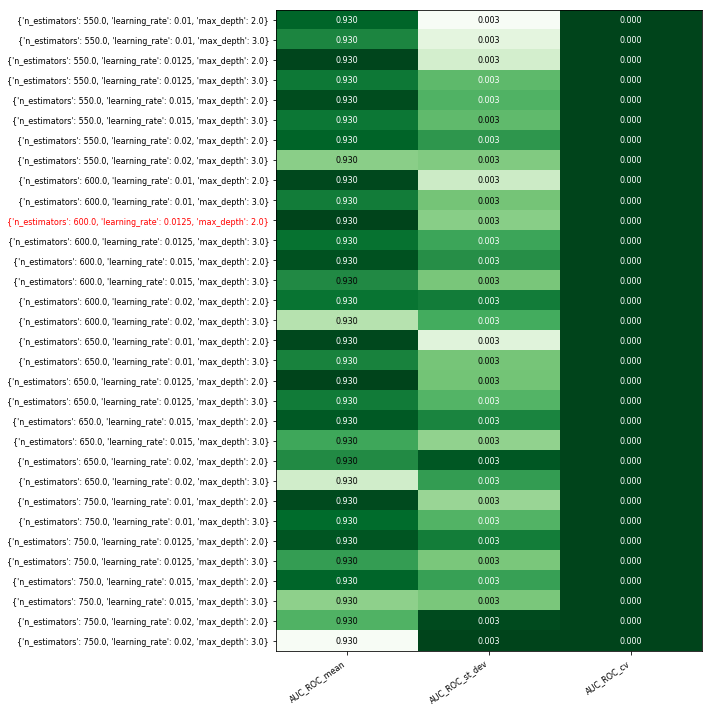

In [15]:
tuner.results.plot_resampled_stats()

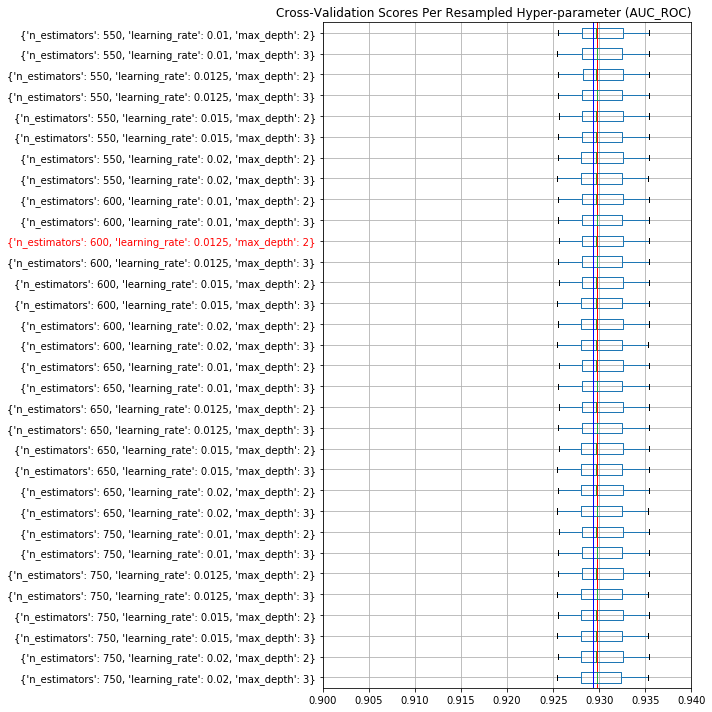

In [16]:
tuner.results.plot_resampled_scores(
    metric=oo.Metric.AUC_ROC,
    x_axis_limits=(0.90, 0.94),
    show_one_ste_rule=True
)

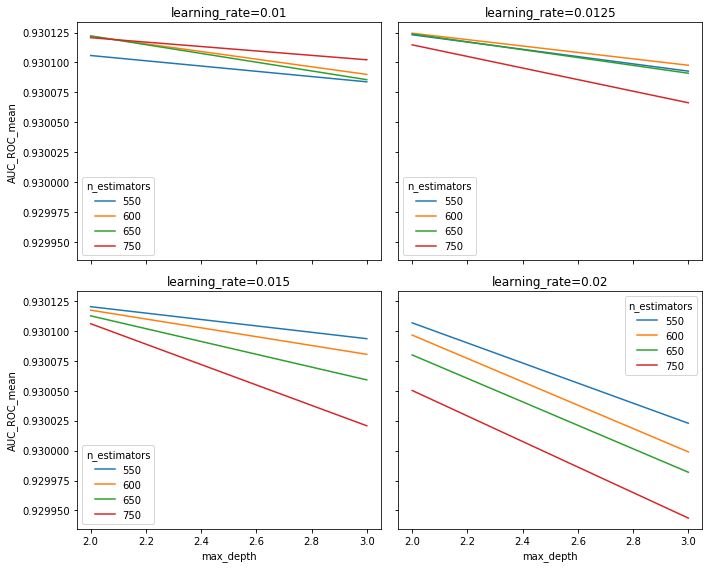

In [17]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.AUC_ROC,
                                        x_axis='max_depth',
                                        line='n_estimators',
                                        grid='learning_rate'
                                       )

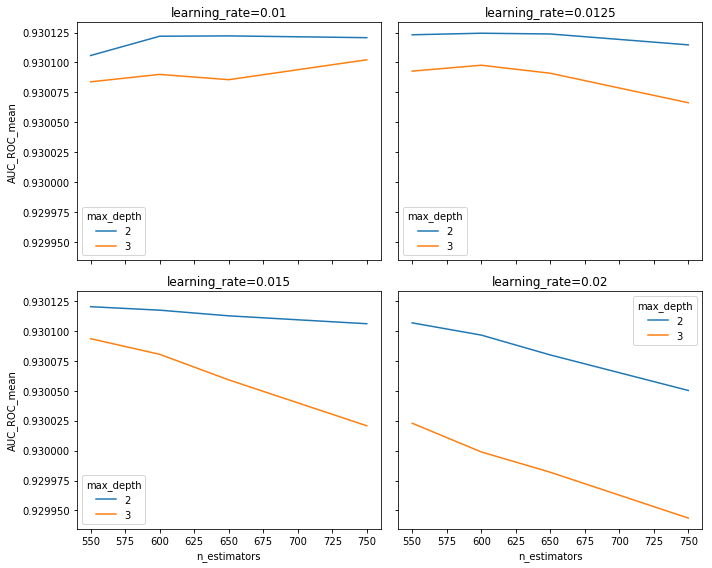

In [18]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.AUC_ROC,
                                        x_axis='n_estimators',
                                        line='max_depth',
                                        grid='learning_rate'
                                       )

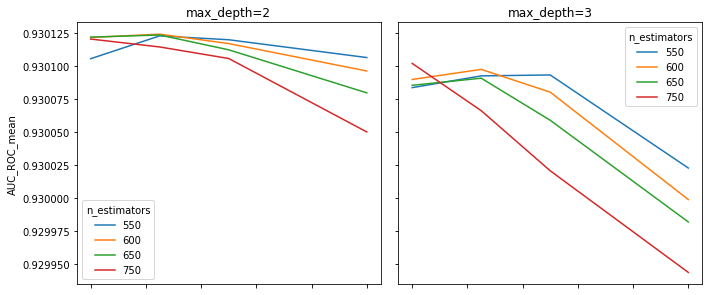

In [19]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.AUC_ROC,
                                        x_axis='learning_rate',
                                        line='n_estimators',
                                        grid='max_depth'
                                       )

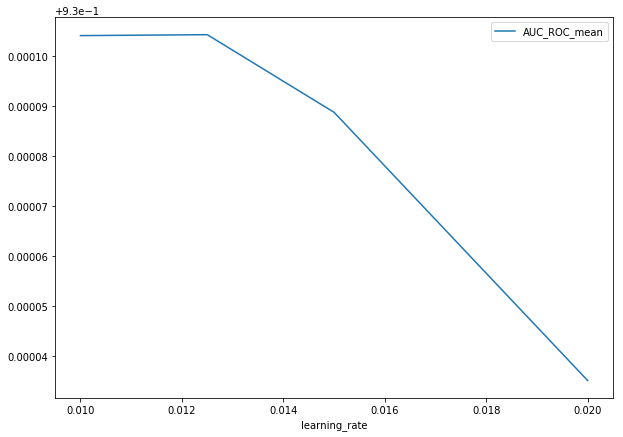

In [20]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.AUC_ROC,
                                        x_axis='learning_rate',
#                                         line='n_estimators',
#                                         grid='max_depth'
                                       )

# Train Final Model (All Data)

In [24]:
fitter = oo.ModelTrainer(
    model=model_stacker,
    # transformations for all models, not just stackers
    model_transformations=global_transformations,
    splitter=None,
    scores=[oo.AucRocScore(positive_class=positive_class)],
)
hyper_params = oo.XGBoostTreeHP(
    objective=oo.XGBObjective.BINARY_LOGISTIC,
    
)
hyper_params.params_dict

{'max_depth': 3,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'silent': True,
 'objective': 'binary:logistic',
 'booster': 'gbtree',
 'n_jobs': 1,
 'nthread': None,
 'gamma': 0,
 'min_child_weight': 1,
 'max_delta_step': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'base_score': 0.5,
 'missing': None}

In [25]:
tuner.results.best_hyper_params

{'n_estimators': 600,
 'learning_rate': 0.0125,
 'max_depth': 2,
 'scale_pos_weight': 3.034796573875803}

In [26]:
hyper_params.update_dict(tuner.results.best_hyper_params)
hyper_params.params_dict

{'max_depth': 2,
 'learning_rate': 0.0125,
 'n_estimators': 600,
 'silent': True,
 'objective': 'binary:logistic',
 'booster': 'gbtree',
 'n_jobs': 1,
 'nthread': None,
 'gamma': 0,
 'min_child_weight': 1,
 'max_delta_step': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 3.034796573875803,
 'base_score': 0.5,
 'missing': None}

In [ ]:
fitter.train_predict_eval(data=explore.dataset,
                          target_variable=target_variable,
                          hyper_params=hyper_params)

In [ ]:
fitter.model.plot_correlation_heatmap()

In [ ]:
fitter.training_scores[0].value

In [ ]:
assert False

# Predict on Kaggle Test Set

In [ ]:
csv_file = '../test_census.csv'
test_dataset = pd.read_csv(csv_file)
test_dataset.shape

In [ ]:
test_dataset.head(100)

In [ ]:
indexes = test_dataset['Unnamed: 0']

predictions = fitter.predict(test_dataset.drop(columns='Unnamed: 0'))
predictions.head(10)

In [ ]:
income_value = predictions['>50K']
new_predictions = pd.DataFrame({'id': indexes, 'income': income_value})
new_predictions.to_csv('submission_ModelStacker_x.csv', index=False)

# Results

## 1)

Kaggle Public: ``

File: `submission_ModelStacker_x.csv`

Parameters: 

```

```